In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting

from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
from pdpbox import pdp, info_plots #for partial plots

np.random.seed(123) #ensure reproducibility
pd.options.mode.chained_assignment = None  #hide any pandas warnings

In [2]:
'''
age: age
sex: sex
cp: chest pain type (4 values)
trtbps: resting blood pressure
chol: serum cholestoral in mg/dl
fbs: fasting blood sugar > 120 mg/dl
restecg: resting electrocardiographic results (values 0,1,2)
thalachh: maximum heart rate achieved
exng: exercise induced angina
oldpeak: oldpeak = ST depression induced by exercise relative to rest
slp: the slope of the peak exercise ST segment
caa: number of major vessels (0-3) colored by flourosopy
thall: thal: 3 = normal; 6 = fixed defect; 7 = reversable defect
'''

heart = pd.read_csv('https://raw.githubusercontent.com/DanielBrooks253/Kaggle/main/Heart_Attack_Analysis/heart.csv')
heart['cp'].replace({1: 'typical_angina', 2: 'atypical_angina', 3: 'non-anginal_pain', 4: 'asymptomatic', 0:'other'}, inplace=True)
heart['restecg'].replace({0:'normal', 1:'ST-T_wave_abnormality', 2:'signs_of_hypertrophy'}, inplace=True)
heart['slp'].replace({1:'upsloping', 2:'flat', 3:'downsloping'}, inplace=True)
heart['exng'].replace({0: 'no', 1:'yes'}, inplace=True)
heart['thall'].replace({1:'normal', 2:'fixed_defect', 3:'reversable_defect', 0:'other'}, inplace=True)
heart['sex'].replace({0:'male', 1:'female'}, inplace=True)
heart['fbs'].replace({0:'lower_120mg/dl', 1:'greater_120mg/dl'}, inplace=True)

heart.head()

,age,sex,cp,trtbps,chol,fbs,restecg,thalachh,exng,oldpeak,slp,caa,thall,output
0,63,female,non-anginal_pain,145,233,greater_120mg/dl,normal,150,no,2.3,0,0,normal,1
1,37,female,atypical_angina,130,250,lower_120mg/dl,ST-T_wave_abnormality,187,no,3.5,0,0,fixed_defect,1
2,41,male,typical_angina,130,204,lower_120mg/dl,normal,172,no,1.4,flat,0,fixed_defect,1
3,56,female,typical_angina,120,236,lower_120mg/dl,ST-T_wave_abnormality,178,no,0.8,flat,0,fixed_defect,1
4,57,male,other,120,354,lower_120mg/dl,ST-T_wave_abnormality,163,yes,0.6,flat,0,fixed_defect,1


<BarContainer object of 2 artists>

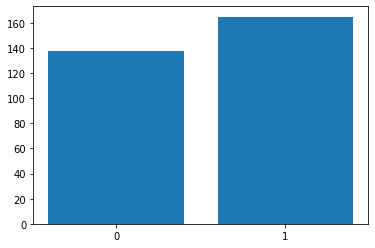

In [3]:
dt = pd.get_dummies(heart, drop_first=True)
counts = {"0": len(heart[heart['output'] == 0]), 
          "1": len(heart[heart['output'] == 1])}

plt.bar(counts.keys(), counts.values()) # Pretty even split

In [4]:
dt.head()

,age,trtbps,chol,thalachh,oldpeak,caa,output,sex_male,cp_non-anginal_pain,cp_other,cp_typical_angina,fbs_lower_120mg/dl,restecg_normal,restecg_signs_of_hypertrophy,exng_yes,slp_flat,slp_upsloping,thall_normal,thall_other,thall_reversable_defect
0,63,145,233,150,2.3,0,1,0,1,0,0,0,1,0,0,0,0,1,0,0
1,37,130,250,187,3.5,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
2,41,130,204,172,1.4,0,1,1,0,0,1,1,1,0,0,1,0,0,0,0
3,56,120,236,178,0.8,0,1,0,0,0,1,1,0,0,0,1,0,0,0,0
4,57,120,354,163,0.6,0,1,1,0,1,0,1,0,0,1,1,0,0,0,0


In [5]:
X_train, X_test, y_train, y_test = train_test_split(dt.drop('output', axis=1),
                                                    dt['output'],
                                                    test_size=.25, 
                                                    random_state=1234)

In [6]:
model = RandomForestClassifier(max_depth=5, n_estimators=100)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, n_estimators=200)

In [7]:
estimator = model.estimators_[0]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

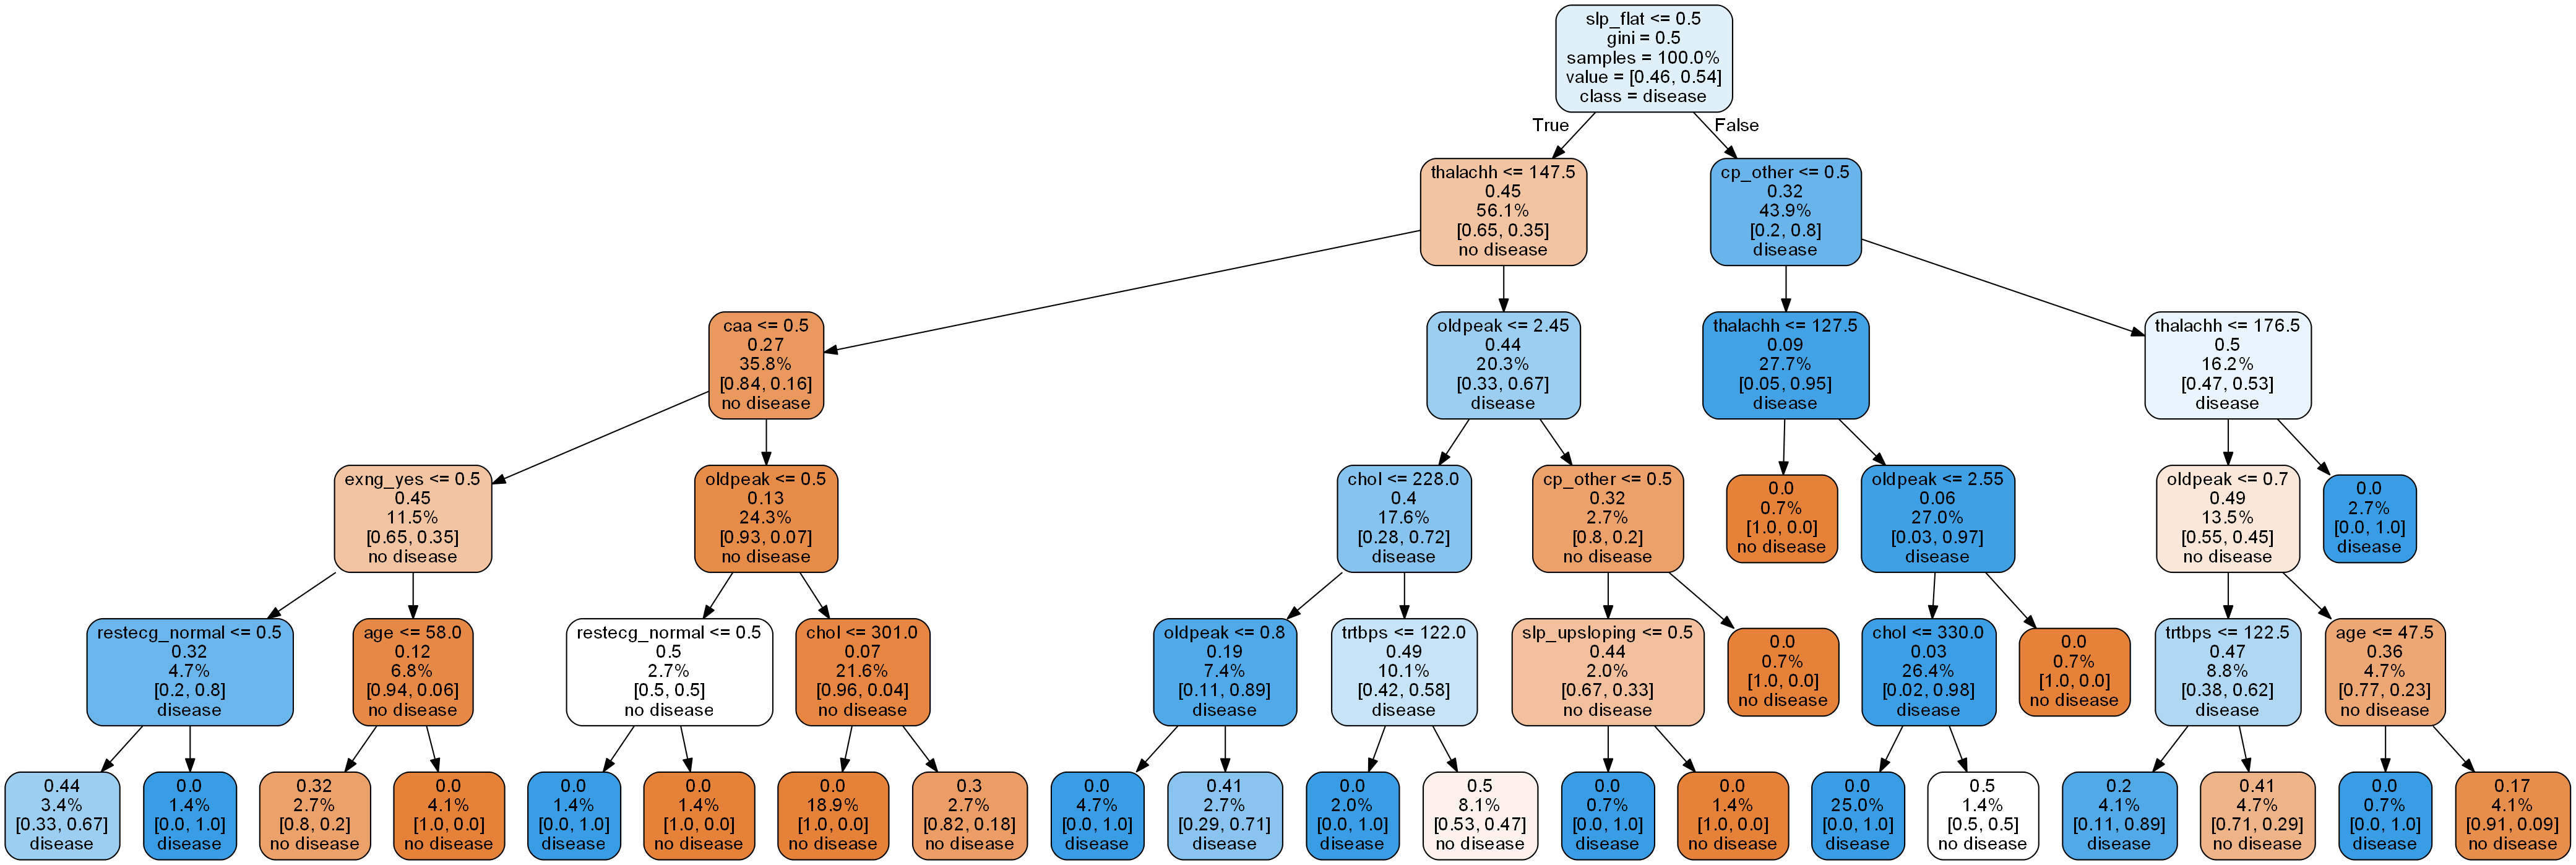

In [8]:
import os
os.environ["PATH"] += os.pathsep + 'C:/Users/daniel.brooks/Anaconda3/Library/bin/graphviz'

export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root',
                precision = 2, filled = True)

from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=150'])

from IPython.display import Image
Image(filename = 'tree.png')

In [9]:
y_predict = pd.Series(model.predict(X_test))
y_pred_quant = model.predict_proba(X_test)[:, 1]

y_predict.replace({0:'no disease', 1:'disease'}, inplace=True)

In [10]:
pd.crosstab(y_test.replace({0:'no disease', 1:'disease'}), y_predict.values, rownames=['Predcition'], colnames=['Acutal'])

Acutal,disease,no disease
Predcition,,
disease,37,5
no disease,10,24


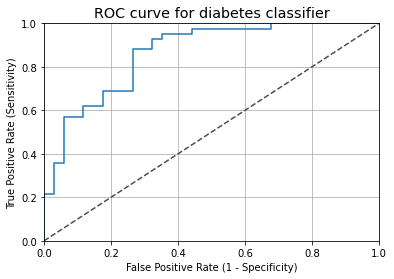

In [11]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [12]:
auc(fpr, tpr)

0.8641456582633054

In [13]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0421 ± 0.0609,cp_other
0.0368 ± 0.0562,caa
0.0184 ± 0.0268,oldpeak
0.0158 ± 0.0197,thall_reversable_defect
0.0132 ± 0.0235,thalachh
0.0105 ± 0.0307,exng_yes
0.0105 ± 0.0307,sex_male
0.0026 ± 0.0105,slp_upsloping
0 ± 0.0000,thall_other
0 ± 0.0000,cp_typical_angina


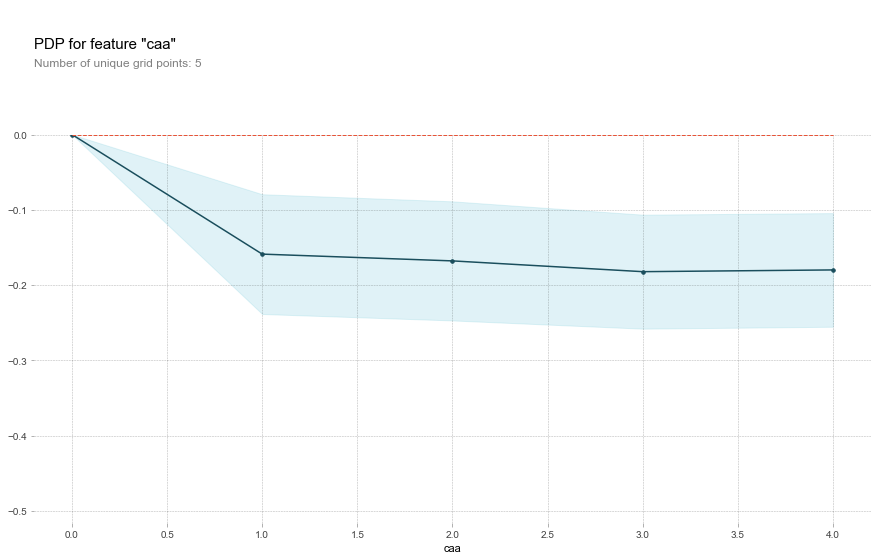

In [19]:
base_features = dt.columns.values.tolist()
base_features.remove('output')

feat_name = 'caa'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

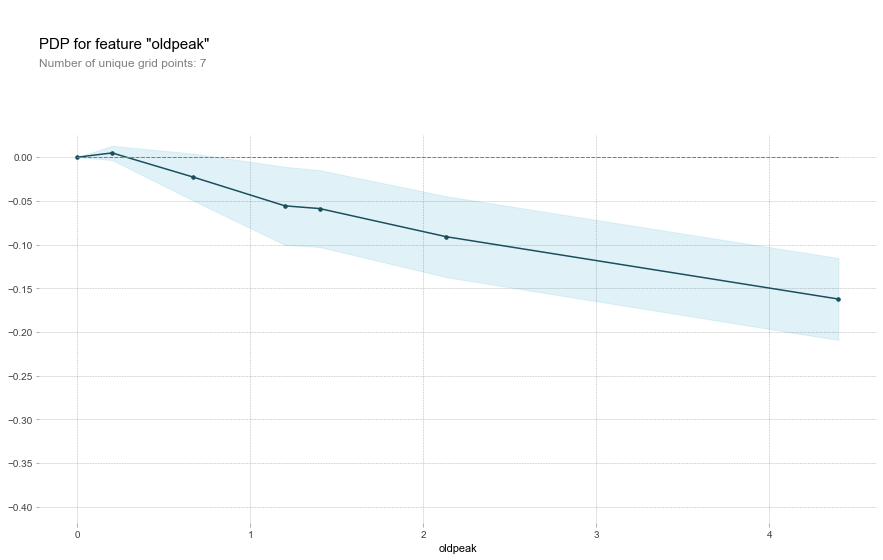

In [21]:
base_features = dt.columns.values.tolist()
base_features.remove('output')

feat_name = 'oldpeak'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()